# Fixed Gamma and Kappa Workflow

This notebook documents the workflow for:
1. Pooling kappa and gamma from training batches
2. Running predictions with fixed gamma and kappa (only lambda is learned)

## Overview

During prediction, we discovered that kappa (calibration parameter) and gamma (genetic effect weights) were being learned per batch, leading to inconsistent values. The solution is to:
- Pool kappa and gamma from the training batches (where they were learned on the full population)
- Fix these values during prediction, so only lambda (individual-specific signature loadings) is learned

This ensures consistent, population-level calibration and genetic effects across all prediction batches.


## Step 1: Pool Kappa and Gamma from Training Batches

First, we pool the kappa and gamma values from all training batch checkpoints to get population-level estimates.


In [ ]:
# Run the pooling script
# This will:
# 1. Load kappa and gamma from all training batch files
# 2. Compute mean kappa (pooled across batches)
# 3. Compute mean gamma (pooled across batches)
# 4. Save to pooled_kappa_gamma.pt

import subprocess
import sys

# Paths
pooling_script = '/Users/sarahurbut/aladynoulli2/claudefile/pool_kappa_and_gamma_from_batches.py'
batch_pattern = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_*.pt'
output_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'

# Run the script
cmd = [
    sys.executable,
    pooling_script,
    '--batch_pattern', batch_pattern,
    '--output_dir', output_dir
]

print("Running pooling script...")
print(f"Command: {' '.join(cmd)}")
print("\n" + "="*80)

result = subprocess.run(cmd, capture_output=True, text=True)

print(result.stdout)
if result.stderr:
    print("\nSTDERR:")
    print(result.stderr)

if result.returncode == 0:
    print("\n✓ Pooling completed successfully!")
else:
    print(f"\n✗ Pooling failed with return code {result.returncode}")


Running pooling script...
Command: /opt/miniconda3/envs/new_env_pyro2/bin/python /Users/sarahurbut/aladynoulli2/claudefile/pool_kappa_and_gamma_from_batches.py --batch_pattern /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_*.pt --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/

POOLING KAPPA AND GAMMA FROM TRAINING BATCHES
Found 40 files matching pattern: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_*.pt
  Loaded kappa=2.884689, gamma shape=(47, 21) from enrollment_model_W0.0001_batch_0_10000.pt
  Loaded kappa=2.925767, gamma shape=(47, 21) from enrollment_model_W0.0001_batch_100000_110000.pt
  Loaded kappa=2.906323, gamma shape=(47, 21) from enrollment_model_W0.0001_batch_10000_20000.pt

KAPPA POOLING RESULTS
  Number of batches: 40
  Pooled kappa (mean): 2.932933
  Std kappa: 0.030100
  Min kappa: 2.884689
  Max kappa: 3.002235

In [ ]:
# Verify the pooled values
import torch
import numpy as np

pooled_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/pooled_kappa_gamma.pt'
pooled_data = torch.load(pooled_path, weights_only=False)

print("Pooled Kappa and Gamma Summary")
print("="*80)
print(f"Kappa: {pooled_data['kappa']:.6f}")
print(f"Gamma shape: {pooled_data['gamma'].shape}")
print(f"Number of batches used: {pooled_data['n_batches']}")

if 'kappa_array' in pooled_data:
    kappa_array = pooled_data['kappa_array']
    print(f"\nKappa statistics across batches:")
    print(f"  Mean: {np.mean(kappa_array):.6f}")
    print(f"  Std: {np.std(kappa_array):.6f}")
    print(f"  Min: {np.min(kappa_array):.6f}")
    print(f"  Max: {np.max(kappa_array):.6f}")

print(f"\nGamma statistics:")
gamma = pooled_data['gamma']
if isinstance(gamma, torch.Tensor):
    gamma = gamma.numpy()
print(f"  Mean |γ|: {np.abs(gamma).mean():.6f}")
print(f"  Max |γ|: {np.abs(gamma).max():.6f}")
print(f"  Shape: {gamma.shape}")


Pooled Kappa and Gamma Summary
Kappa: 2.932933
Gamma shape: (47, 21)
Number of batches used: 40

Kappa statistics across batches:
  Mean: 2.932933
  Std: 0.030100
  Min: 2.884689
  Max: 3.002235

Gamma statistics:
  Mean |γ|: 0.000205
  Max |γ|: 0.007480
  Shape: (47, 21)


## Step 2: Run Predictions with Fixed Gamma and Kappa

Now we run the prediction script using the pooled gamma and kappa values. This ensures:
- Consistent calibration (kappa) across all batches
- Consistent genetic effects (gamma) across all batches
- Only lambda (individual signature loadings) is learned per batch


In [ ]:
# Example command to run predictions with fixed gamma and kappa
# This can be run in a terminal or as a background job

prediction_script = '/Users/sarahurbut/aladynoulli2/claudefile/run_aladyn_predict_with_master_vector_cenosrE_fixedgk.py'
master_checkpoint = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_correctedE.pt'
pooled_gk_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/pooled_kappa_gamma.pt'
output_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_fixedgk_vectorized/'

# Example command (commented out - uncomment to run)
example_cmd = f"""
python {prediction_script} \\
    --trained_model_path {master_checkpoint} \\
    --pooled_gamma_kappa_path {pooled_gk_path} \\
    --output_dir {output_dir} \\
    --batch_size 10000 \\
    --num_epochs 200 \\
    --learning_rate 0.1 \\
    --lambda_reg 0.01 \\
    --max_batches 40
"""

print("Example command to run predictions:")
print("="*80)
print(example_cmd)
print("="*80)
print("\nTo run in background:")
print(f"nohup python {prediction_script} \\")
print(f"    --trained_model_path {master_checkpoint} \\")
print(f"    --pooled_gamma_kappa_path {pooled_gk_path} \\")
print(f"    --output_dir {output_dir} \\")
print(f"    --max_batches 40 \\")
print(f"    > predict_fixedgk.log 2>&1 &")


Example command to run predictions:

python /Users/sarahurbut/aladynoulli2/claudefile/run_aladyn_predict_with_master_vector_cenosrE_fixedgk.py \
    --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_correctedE.pt \
    --pooled_gamma_kappa_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/pooled_kappa_gamma.pt \
    --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_fixedgk_vectorized/ \
    --batch_size 10000 \
    --num_epochs 200 \
    --learning_rate 0.1 \
    --lambda_reg 0.01 \
    --max_batches 40


To run in background:
nohup python /Users/sarahurbut/aladynoulli2/claudefile/run_aladyn_predict_with_master_vector_cenosrE_fixedgk.py \
    --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_correctedE.pt \
    --pooled_gamma_kappa_path /Users/sarahurbut/Library/CloudStorage/Drop

In [ ]:
# Optionally: Run a test batch to verify everything works
# Uncomment to run a single batch test

# import subprocess
# import sys

# test_cmd = [
#     sys.executable,
#     prediction_script,
#     '--trained_model_path', master_checkpoint,
#     '--pooled_gamma_kappa_path', pooled_gk_path,
#     '--output_dir', output_dir + '_test',
#     '--batch_size', '10000',
#     '--num_epochs', '10',  # Fewer epochs for testing
#     '--max_batches', '1',  # Just one batch
# ]

# print("Running test batch...")
# result = subprocess.run(test_cmd, capture_output=True, text=True)
# print(result.stdout)
# if result.stderr:
#     print("\nSTDERR:")
#     print(result.stderr)


## Step 3: Verify Predictions

After running predictions, verify that:
1. All batches completed successfully
2. Predictions are concatenated into a single file
3. The model used fixed gamma and kappa (check batch_info.pt)


In [ ]:
# Check prediction results
import torch
from pathlib import Path

output_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_fixedgk_vectorized/'
info_path = Path(output_dir) / 'batch_info.pt'
full_pi_path = Path(output_dir) / 'pi_enroll_fixedphi_sex_FULL.pt'

print("Verifying Predictions")
print("="*80)

# Check if batch info exists
if info_path.exists():
    batch_info = torch.load(info_path, weights_only=False)
    print(f"✓ Batch info found")
    print(f"  Total batches: {len(batch_info['batches'])}")
    print(f"  Total patients: {batch_info['total_patients']:,}")
    print(f"  Diseases: {batch_info['n_diseases']}")
    print(f"  Timepoints: {batch_info['n_timepoints']}")
    if 'gamma_shape' in batch_info:
        print(f"  Gamma shape used: {batch_info['gamma_shape']}")
    if 'kappa_value' in batch_info:
        print(f"  Kappa value used: {batch_info['kappa_value']:.6f}")
else:
    print(f"✗ Batch info not found at {info_path}")

# Check if full predictions exist
if full_pi_path.exists():
    pi_full = torch.load(full_pi_path, weights_only=False)
    print(f"\n✓ Full predictions found")
    print(f"  Shape: {pi_full.shape}")
    print(f"  Mean pi: {pi_full.mean():.6f}")
    print(f"  Min pi: {pi_full.min():.6f}")
    print(f"  Max pi: {pi_full.max():.6f}")
else:
    print(f"\n✗ Full predictions not found at {full_pi_path}")

# List all batch files
batch_files = sorted(Path(output_dir).glob('pi_enroll_fixedphi_sex_*_*.pt'))
if batch_files:
    print(f"\n✓ Found {len(batch_files)} batch prediction files")
    print(f"  First: {batch_files[0].name}")
    print(f"  Last: {batch_files[-1].name}")
else:
    print(f"\n✗ No batch prediction files found")


Verifying Predictions
✓ Batch info found
  Total batches: 40
  Total patients: 400,000
  Diseases: 348
  Timepoints: 52
  Gamma shape used: (47, 21)
  Kappa value used: 2.932933

✓ Full predictions found
  Shape: torch.Size([400000, 348, 52])
  Mean pi: 0.000795
  Min pi: 0.000000
  Max pi: 0.118210

✓ Found 40 batch prediction files
  First: pi_enroll_fixedphi_sex_0_10000.pt
  Last: pi_enroll_fixedphi_sex_90000_100000.pt


## Summary

This workflow ensures that:
1. **Kappa** (calibration parameter) is fixed at the population level, preventing per-batch calibration issues
2. **Gamma** (genetic effect weights) is fixed at the population level, ensuring consistent genetic effects
3. **Lambda** (individual signature loadings) is still learned per batch, allowing for individual-specific predictions

The key advantage is that predictions will have consistent calibration and genetic effects across all batches, matching the training population parameters.


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_52796/1535218006.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_full = torch.load("/Users/sarahurbut/Libr

✓ Loaded pre-computed pi: torch.Size([50000, 348, 52])
✓ Loaded Y: torch.Size([50000, 348, 52])
✓ Loaded E_corrected: torch.Size([50000, 348])
✓ Loaded cov_df: 50000 patients

Dataset dimensions: 50000 patients × 348 diseases × 52 timepoints

Creating at-risk mask...
  Processing patient 0/50000...
✓ At-risk mask created

  Processing timepoint 0/52...
  Processing timepoint 10/52...
  Processing timepoint 20/52...
  Processing timepoint 30/52...
  Processing timepoint 40/52...
  Processing timepoint 50/52...

✓ Collected 738,708,915 predictions/observations
  Mean predicted: 5.56e-04
  Mean observed: 5.45e-04

Creating calibration plot...

✓ Saved calibration plot to: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/fig5/calibration_plots_full_400k_fixedgk.pdf


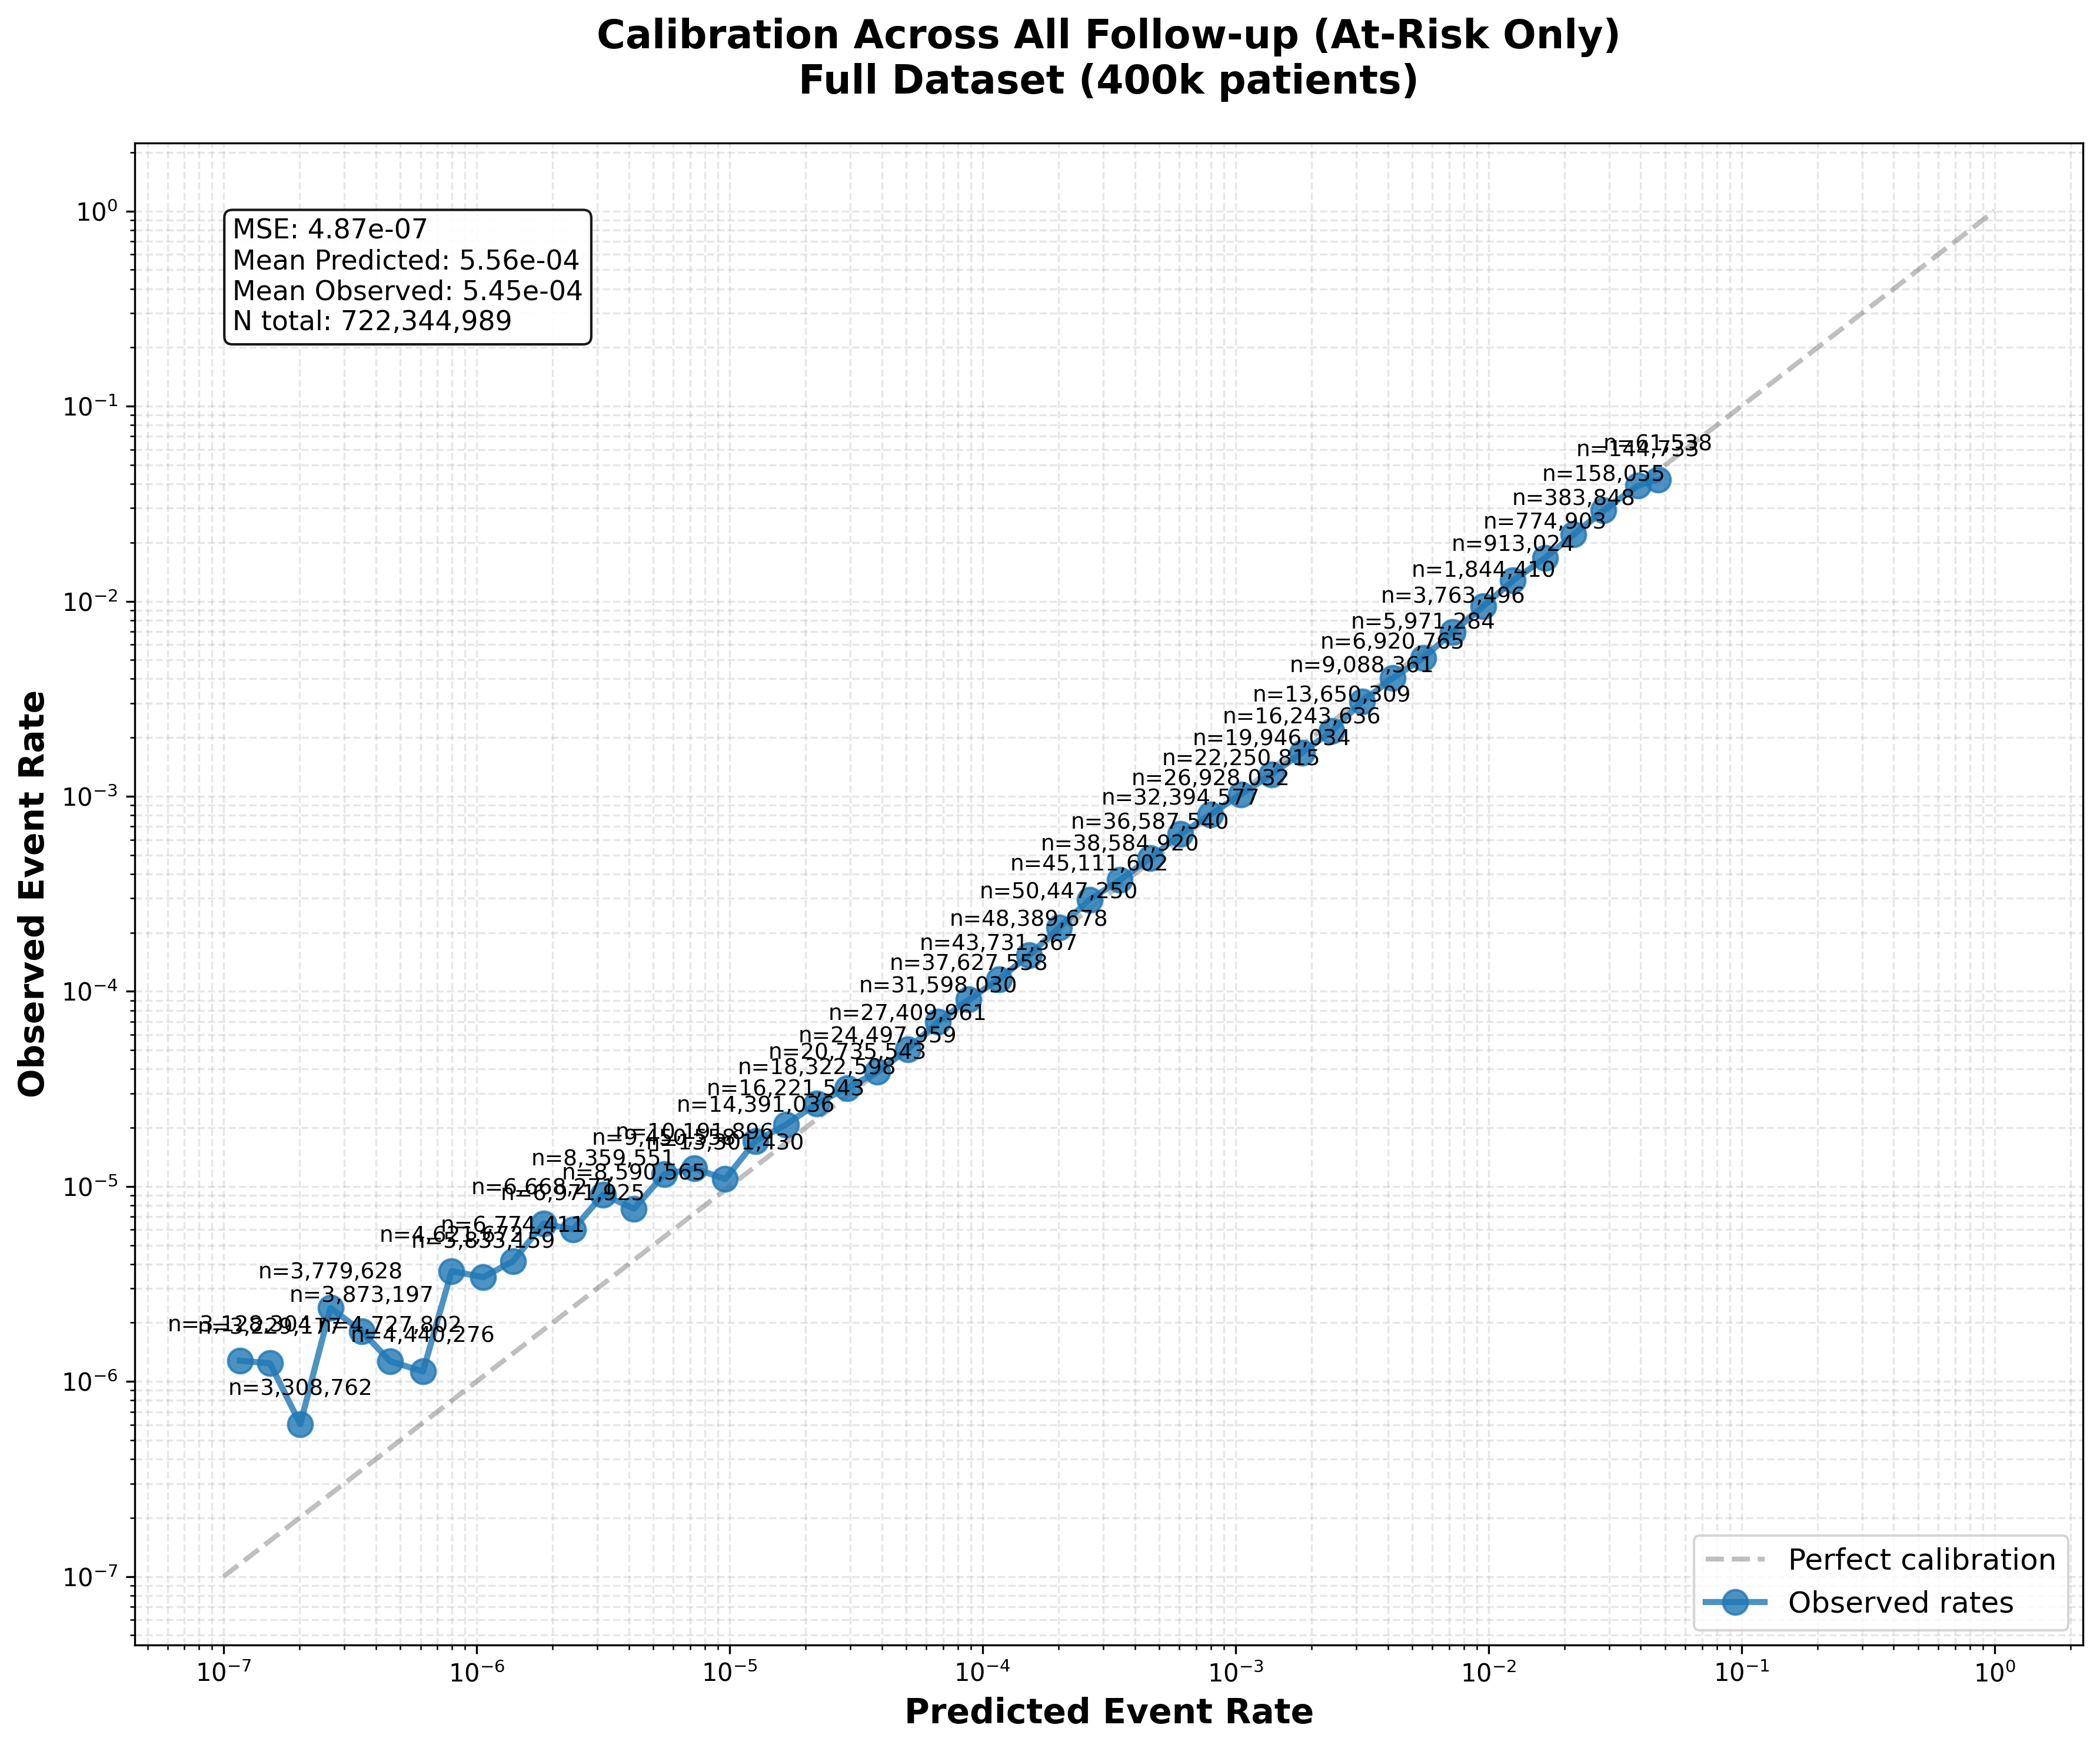

In [ ]:
# ============================================================================
# Full Dataset Calibration: 400k patients using pre-computed pi
# ============================================================================

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load pre-computed pi (full 400k dataset)
#pi_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/pi_fullmode_400k.pt", map_location='cpu', weights_only=False)[:50000]

pi_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_fixedgk_vectorized/pi_enroll_fixedphi_sex_FULL.pt", 
           )[:50000]                   
print(f"✓ Loaded pre-computed pi: {pi_full.shape}")

# Load Y (full dataset)
Y_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt", 
                    map_location='cpu', weights_only=False)[:50000]
print(f"✓ Loaded Y: {Y_full.shape}")

# Load corrected E matrix (full dataset)
E_corrected_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/E_matrix_corrected.pt", 
                              map_location='cpu', weights_only=False)[:50000]
print(f"✓ Loaded E_corrected: {E_corrected_full.shape}")

# Load covariates (full dataset)
cov_df_full = pd.read_csv("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/baselinagefamh_withpcs.csv")[:50000]
print(f"✓ Loaded cov_df: {len(cov_df_full)} patients")

# Convert to numpy
pi_np = pi_full.detach().numpy()
Y_np = Y_full.detach().numpy()
if torch.is_tensor(E_corrected_full):
    E_corrected_np = E_corrected_full.detach().numpy()
else:
    E_corrected_np = E_corrected_full

N, D, T = Y_np.shape
print(f"\nDataset dimensions: {N} patients × {D} diseases × {T} timepoints")

# Create at_risk mask using corrected E matrix
print("\nCreating at-risk mask...")
at_risk = np.zeros((N, D, T), dtype=bool)
for n in range(N):
    if n % 50000 == 0:
        print(f"  Processing patient {n}/{N}...")
    for d in range(D):
        # Patient is at risk at timepoint t if event/censor time >= t
        at_risk[n, d, :] = (E_corrected_np[n, d] >= np.arange(T))

print("✓ At-risk mask created")

# Collect all predictions and observations (at-risk only)
print("\nCollecting predictions and observations...")
all_pred = []
all_obs = []

for t in range(T):
    if t % 10 == 0:
        print(f"  Processing timepoint {t}/{T}...")
    mask_t = at_risk[:,:,t]
    if mask_t.sum() > 0:
        all_pred.extend(pi_np[:,:,t][mask_t])
        all_obs.extend(Y_np[:,:,t][mask_t])

all_pred = np.array(all_pred)
all_obs = np.array(all_obs)

print(f"\n✓ Collected {len(all_pred):,} predictions/observations")
print(f"  Mean predicted: {all_pred.mean():.2e}")
print(f"  Mean observed: {all_obs.mean():.2e}")

# Create calibration plot
print("\nCreating calibration plot...")
fig, ax = plt.subplots(figsize=(12, 10), dpi=300)

# Create bins in log space
n_bins = 50
min_bin_count = 10000  # Higher threshold for full dataset
use_log_scale = True

if use_log_scale:
    bin_edges = np.logspace(np.log10(max(1e-7, min(all_pred))), 
                          np.log10(max(all_pred)), 
                          n_bins + 1)
else:
    bin_edges = np.linspace(min(all_pred), max(all_pred), n_bins + 1)

# Calculate statistics for each bin
bin_means = []
obs_means = []
counts = []

for i in range(n_bins):
    mask = (all_pred >= bin_edges[i]) & (all_pred < bin_edges[i + 1])
    if np.sum(mask) >= min_bin_count:
        bin_means.append(np.mean(all_pred[mask]))
        obs_means.append(np.mean(all_obs[mask]))
        counts.append(np.sum(mask))

# Plot
if use_log_scale:
    ax.plot([1e-7, 1], [1e-7, 1], '--', color='gray', alpha=0.5, label='Perfect calibration', linewidth=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
else:
    ax.plot([0, max(all_pred)], [0, max(all_pred)], '--', color='gray', alpha=0.5, label='Perfect calibration', linewidth=2)

ax.plot(bin_means, obs_means, 'o-', color='#1f77b4', 
        markersize=10, linewidth=2.5, label='Observed rates', alpha=0.8)

# Add counts as annotations
for i, (x, y, c) in enumerate(zip(bin_means, obs_means, counts)):
    ax.annotate(f'n={c:,}', (x, y), xytext=(0, 12), 
               textcoords='offset points', ha='center', fontsize=9)

# Add summary statistics
mse = np.mean((np.array(bin_means) - np.array(obs_means))**2)
mean_pred = np.mean(all_pred)
mean_obs = np.mean(all_obs)

stats_text = f'MSE: {mse:.2e}\n'
stats_text += f'Mean Predicted: {mean_pred:.2e}\n'
stats_text += f'Mean Observed: {mean_obs:.2e}\n'
stats_text += f'N total: {sum(counts):,}'

ax.text(0.05, 0.95, stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
        fontsize=11)

ax.grid(True, which='both', linestyle='--', alpha=0.3)
ax.set_xlabel('Predicted Event Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('Observed Event Rate', fontsize=14, fontweight='bold')
ax.set_title('Calibration Across All Follow-up (At-Risk Only)\nFull Dataset (400k patients)', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=12)

plt.tight_layout()

# Save plot
save_path = "/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/fig5/calibration_plots_full_400k_fixedgk.pdf"
plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved calibration plot to: {save_path}")

plt.show()


In [ ]:
# Run AUC evaluations on full 400k dataset
import subprocess
import sys

script_path = '/Users/sarahurbut/aladynoulli2/claudefile/evaluate_fixedgk_full_400k_auc.py'

cmd = [
    sys.executable,
    script_path,
    '--n_bootstraps', '100',
    '--max_patients', '400000'
]

print("Running AUC evaluation script...")
print(f"Command: {' '.join(cmd)}")
print("="*80)

result = subprocess.run(cmd, capture_output=True, text=True)

print(result.stdout)
if result.stderr:
    print("\nSTDERR:")
    print(result.stderr)

if result.returncode == 0:
    print("\n✓ AUC evaluation completed successfully!")
else:
    print(f"\n✗ AUC evaluation failed with return code {result.returncode}")

Running AUC evaluation script...
Command: /opt/miniconda3/envs/new_env_pyro2/bin/python /Users/sarahurbut/aladynoulli2/claudefile/evaluate_fixedgk_full_400k_auc.py --n_bootstraps 100 --max_patients 400000
EVALUATING FIXED GAMMA/KAPPA PREDICTIONS - FULL 400K DATASET
Pi file: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_fixedgk_vectorized/pi_enroll_fixedphi_sex_FULL.pt
Max patients: 400000
Bootstrap iterations: 100

Loading full data files...

Loading predictions from /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_fixedgk_vectorized/pi_enroll_fixedphi_sex_FULL.pt...
Loaded pi: torch.Size([400000, 348, 52])
Using 400,000 patients for evaluation
Data shapes: pi=torch.Size([400000, 348, 52]), Y=torch.Size([400000, 348, 52]), E=torch.Size([400000, 348]), pce_df=400000

EVALUATING STATIC 10-YEAR AUC

Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC: 0.696 (0.692-0.698) (calculated on 400000 individuals)
Events (10-Year i

In [ ]:
# Compare fixed gamma/kappa results with original results
import subprocess
import sys

script_path = '/Users/sarahurbut/aladynoulli2/claudefile/compare_fixedgk_vs_original_full_400k.py'

cmd = [
    sys.executable,
    script_path
]

print("Running comparison script...")
print(f"Command: {' '.join(cmd)}")
print("="*80)

result = subprocess.run(cmd, capture_output=True, text=True)

print(result.stdout)
if result.stderr:
    print("\nSTDERR:")
    print(result.stderr)

if result.returncode == 0:
    print("\n✓ Comparison completed successfully!")
else:
    print(f"\n✗ Comparison failed with return code {result.returncode}")

Running comparison script...
Command: /opt/miniconda3/envs/new_env_pyro2/bin/python /Users/sarahurbut/aladynoulli2/claudefile/compare_fixedgk_vs_original_full_400k.py
COMPARING FIXED GAMMA/KAPPA VS ORIGINAL RESULTS - FULL 400K

Loading results...
Fixed GK static: 28 diseases
Fixed GK dynamic: 28 diseases
Original static: 28 diseases
Original dynamic: 28 diseases

STATIC 10-YEAR AUC COMPARISON

Top 10 diseases by absolute AUC difference:
--------------------------------------------------------------------------------
Disease                        Original AUC    Fixed GK AUC    Difference     
--------------------------------------------------------------------------------
ASCVD                            0.7329          0.6959         -0.0370
Diabetes                         0.6302          0.6021         -0.0281
Ulcerative_Colitis               0.5827          0.5707         -0.0119
Thyroid_Disorders                0.5850          0.5742         -0.0108
Osteoporosis                  

# let's also do with pooled unregularized gammas



In [ ]:
''' 
python /Users/sarahurbut/aladynoulli2/claudefile/pool_kappa_and_gamma_from_nolr_batches.py

nohup python /Users/sarahurbut/aladynoulli2/claudefile/run_aladyn_predict_with_master_vector_cenosrE_fixedgk.py \
    --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_correctedE.pt \
    --pooled_gamma_kappa_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/pooled_kappa_gamma_nolr.pt \
    --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_fixedgk_nolr_vectorized/ \
    --num_epochs 200 \
    --learning_rate 1e-1 \
    --start_batch 5 \
    > predict_fixedgk_nolr.log 2>&1 &

'''

In [ ]:
%run /Users/sarahurbut/aladynoulli2/claudefile/compare_regularized_vs_unregularized_phis_lambdas.py

COMPARING REGULARIZED vs UNREGULARIZED PHIS AND LAMBDAS

LOADING REGULARIZED PHI FROM MASTER CHECKPOINT
Regularized phi shape: (21, 348, 52)
Regularized phi range: [-22.8308, -1.9764]
Regularized phi mean: -10.9054

LOADING UNREGULARIZED PHI FROM BATCHES
Found 40 files matching pattern
Pooled phi from 40 batches, shape: (21, 348, 52)
Unregularized phi range: [-22.8308, -1.9764]
Unregularized phi mean: -10.9054

PHI COMPARISON
Pearson correlation: 1.000000 (p=0.00e+00)
Mean absolute difference: 0.000001
Max absolute difference: 0.000502
Mean relative difference: 0.0000%

Per-signature comparison (mean absolute difference):
  Signature 0: 0.000001
  Signature 1: 0.000002
  Signature 2: 0.000002
  Signature 3: 0.000002
  Signature 4: 0.000001
  Signature 5: 0.000002
  Signature 6: 0.000001
  Signature 7: 0.000002
  Signature 8: 0.000001
  Signature 9: 0.000001
  Signature 10: 0.000001
  Signature 11: 0.000001
  Signature 12: 0.000001
  Signature 13: 0.000001
  Signature 14: 0.000001
  Sig